# Install
Before we begin, if you don't already have it you will need to install the following packages. Here is the install command:

**transformers**: `conda install -c conda-forge transformers`

It's important to note that my code differs from Kexin's because I [migrated](https://huggingface.co/transformers/migration.html) to using [HuggingFace's](https://huggingface.co/transformers/index.html) new `transformer` module instead of the formerly known as `pytorch_pretrained_bert` that the author used. 

# Read this article for ClinicalBERT
https://arxiv.org/pdf/1904.05342.pdf
They develop ClinicalBert by applying BERT (bidirectional encoder representations from transformers) to clinical notes. 

```
@article{clinicalbert,
author = {Kexin Huang and Jaan Altosaar and Rajesh Ranganath},
title = {ClinicalBERT: Modeling Clinical Notes and Predicting Hospital Readmission},
year = {2019},
journal = {arXiv:1904.05342},
}
```

# How My Work Differs from the Author's
1. I am not pre-training the ClinicalBERT because the author already performed pre-training on Clinical words and the model's weights are already available.
2. I am only working with early clinical notes. "Discharge summaries have predictive power for readmission. However, discharge summaries might be written after a patient has left the hospital. Therefore, discharge summaries are not actionable since doctors cannot intervene when a patient has left the hospital. Models that dynamically predict readmission in the early stages of a patient's admission are relevant to clinicians...a maximum of the first 48 or 72 hours of a patient's notes are concatenated. These concatenated notes are used to predict readmission."[pg 12](https://arxiv.org/pdf/1904.05342.pdf)


<img src="./images/fig1.png" width="800" />

In this example, care providers add notes to an electronic health record during a patient’s admission, and the model dynamically updates the patient’s risk of being readmitted within a 30-day window.


Boag et al. (2018) study the performance of the bag-of-words model, word2vec, and a Long Short-Term Memory Network (lstm) model combined with word2vec on various tasks such as diagnosis prediction and mortality risk estimation. Word embedding models such as word2vec are trained using the local context of individual words, but as clinical notes are long and their words are interdependent (Zhang et al., 2018), these methods cannot capture long-range dependencies.

Clinical notes require capturing interactions between distant words.

In this work, they develop a model that can predict readmission dynamically. **Making a prediction using a discharge summary at the end of a stay means that there are fewer opportunities to reduce the chance of readmission. To build a clinically-relevant model, we define a task for predicting readmission at any timepoint since a patient was admitted.**

Medicine suffers from alarm fatigue (Sendelbach and Funk, 2013). This
means useful classification rules for medicine need to have high precision (positive predictive value).

Compared to a popular model of clinical text, word2vec, ClinicalBert more accurately captures clinical word similarity.

ClinicalBERT is a modified BERT model: Specifically, the representations are learned
using medical notes and further processed for downstream clinical tasks.
* The transformer encoder architecture is based on a self-attention mechanism
* The pre-training objective function for the model is defined using two unsupervised tasks: masked language modeling and next sentence prediction. 
* The text embeddings and model parameters are fit using stochastic optimization.

<img src="./images/fig2.png" width="800" />

ClinicalBert learns deep representations of clinical text using two unsupervised language modeling tasks: masked language modeling and
next sentence prediction

### Clinical Text Embeddings
A clinical note input to ClinicalBert is represented as a collection of tokens. In ClinicalBert, a token in a clinical note is computed as
the sum of the token embedding, a learned segment embedding, and a position embedding.

### Pre-training ClinicalBERT
The quality of learned representations of text depends on the text the model was trained on. BERT is trained on BooksCorpus and Wikipedia. However, these two datasets are distinct from clinical notes (where jargon and abbreviations are common). Also clinical notes have different syntax and grammar than common language in books or encyclopedias. It is hard to understand clinical notes without professional training.

ClinicalBERT improves over BERT on the MIMIC-III corpus of clinical notes for 
1. Accuracy of masked language modeling a.k.a. predicting held-out tokens (86.80% vs 56.80%).
2. Next sentence prediction (99.25% vs. 80.50%).
The pre-training objective function based on the two tasks is the sum of the log-likelihood of the masked tokens and the log-likelihood of the binary variable indicating whether two sentences are consecutive.

### Fine-tuning ClinicalBERT
The model parameters are fine-tuned to maximize the log-likelihood of this binary classifier: equation (2)

##  Empirical Study II: 30-Day Hospital Readmission Prediction
Before the author even evaluated ClinicalBERT's performance as a model of readmission, **his initial experiment showed that the original BERT suffered in performance on the masked language modeling task on the MIMIC-III data as well as the next sentence prediction tasks. This proves the need develop models tailored to clinical data such as ClinicalBERT!**

<img src="./images/equ3.png" width="600" />

He finds that computing readmission probability using Equation (3) consistently outperforms predictions on each subsequence individually by 3–8%. This is because
1. some subsequences (such as tokens corresponding to progress reports) do NOT contain information about readmission, whereas others do. The risk of readmission should be computed using subsequences that correlate with readmission risk, and **the effect of unimportant subsequences should be minimized**. This is accomplished by using the maximum probability over subsequences. 
2. Also noisy subsequences mislead the model and decrease performance. So they also include the average probability of readmission across subsequences. This leads to a trade-off between the mean and maximum probabilities of readmission in Equation (3).
3. if there are a large number of subsequences for a patient with many clinical notes, there is a higher probability of having a noisy maximum probability of readmission. This means longer sequences may need to have a larger weight on the mean prediction. We include this weight as the n/c scaling factor, with c adjusting for patients with many clinical notes.
Empirically, he found that c = 2 performs best on validation data.

### Evaluation
For validation and testing, 10% of the data is held out respectively, and 5-fold cross-validation is conducted. 

Each model is evaluated using three metrics:
1. AUROC
2. Area under the precision-recall curve
3. Recall at precision of 80%: For the readmission task, false positives are important. To minimize the number of false positives and thus minimize the risk of alarm fatigue, he set the precision to 80% (in other words, 20% false positives out of the predicted positive class) and use the corresponding threshold to calculate recall. This leads to a clinically-relevant metric that enables us to build models that control the false positive rate. 

### Models
* The training parameters are the entire encoder network, along with the classifier **`W`**
* Note that the data labels are imbalanced: negative labels are subsampled to balance the positive readmit labels
* ClinicalBert is trained for one epoch with batch size 4 and ee use the Adam optimizer learning rate 2 × 10−5
*  The ClinicalBert model settings are the same as in Section 3.
* The binary classifier is a linear layer of shape 768 × 1
* The maximum sequence length supported by the model is set to 512, and the model is first trained using shorter sequences.

<img src="./images/tab3.png" width="600" />

Shows that ClinicalBERT outperforms it's competitors like Bag-of-words (Top 5000 TF-IDF words as features) and BiLSTM/Word2Vec in terms of precision and recall.

###  Readmission Prediction With Early Clinical Notes
Discharge summaries have predictive power for readmission. However, discharge summaries
might be written after a patient has left the hospital. Therefore, discharge summaries are
not actionable since doctors cannot intervene when a patient has left the hospital. Models
that dynamically predict readmission in the early stages of a patient’s admission are relevant to clinicians.

> **Note** that readmission predictions from a model are not actionable if a patient has been discharged. 

**24-48h**
* In the MIMIC-III data, admission and discharge times are available, but clinical notes do not have timestamps. This is why the table headings show a range; this range shows the cutoff time for notes fed to the model from early on in a patient’s admission. For example, in the 24–48h column, the model may only take as input a patient’s notes up to 36h because of that patient’s specific admission time.

**48-72h**
* For the second set of readmission prediction experiments, a maximum of the first 48 or 72 hours of a patient’s notes are concatenated. These concatenated notes are used to predict readmission. Since we separate notes into subsequences of the same length, the training set consists of all subsequences within a maximum of 72 hours, and the model is tested given only available notes within the first 48 or 72 hours of a patient’s admission.
* For testing 48 or 72-hour clinical note readmission prediction, patients that are discharged within 48 or 72 hours (respectively) are filtered out.

### Interpretable predictions in ClinicalBert
* ClinicalBert uses several self-attention mechanisms which can be used to inspect its predictions, by visualizing terms correlated with predictions of hospital readmission.
    * For every clinical note input to ClinicalBert, each self-attention mechanism computes a distribution over every term in a sentence, given a query.
    * **A high attention weight between a query and key token means the interaction between these tokens is predictive of readmission**.
    *  In the ClinicalBert encoder, there are 144 self-attention mechanisms (or, 12 multi-head attention mechanisms for each of the 12 transformer encoders). 
  

### Preprocessing
ClinicalBert requires minimal preprocessing:
1. First, words are converted to lowercase and
2. line breaks are removed
3. carriage returns are removed. 
4. De-identified the brackets 
5. remove special characters like ==, −−

* The SpaCy sentence segmentation package is used to segment each note (Honnibal and Montani, 2017).
    * Since clinical notes don't follow rigid standard language grammar, we find rule-based segmentation has better results than dependency parsing-based segmentation.
    * Various segmentation signs that misguide rule-based segmentators are removed or replaced
        * For example 1.2 would be removed
        * M.D., dr. would be replaced with with MD, Dr
    * Clinical notes can include various lab results and medications that also contain numerous rule-based separators, such as 20mg, p.o., q.d.. (where q.d. means one a day and q.o. means to take by mouth.  
        *  To address this, segmentations that have less than 20 words are fused into the previous segmentation so that they are not singled out as different sentences.

# Preprocess.py

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

10/14/2023 22:05:49 - INFO - matplotlib.font_manager -   Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
10/14/2023 22:05:49 - INFO - matplotlib.font_manager -   Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
10/14/2023 22:05:49 - INFO - matplotlib.font_manager -   Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
10/14/2023 22:05:49 - INFO - matplotlib.font_manager -   generated new fontManager


Convert Strings to Dates.
When converting dates, it is safer to use a datetime format. 
Setting the errors = 'coerce' flag allows for missing dates 
but it sets it to NaT (not a datetime)  when the string doesn't match the format.

In [2]:
# Load ADMISSIONS table from AWS S3 bucket
bucket = 's3://mimic-iii-physionet'
data_key = 'ADMISSIONS.csv.gz'
data_location = 's3://{}/{}'.format(bucket, data_key)
df_adm = pd.read_csv(data_location)

In [2]:
# Load ADMISSIONS table
df_adm = pd.read_csv('./ADMISSIONS.csv')
#     '/Users/nwams/Documents/Machine Learning Projects/Predicting-Hospital-Readmission-using-NLP/ADMISSIONS.csv')

In [3]:
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')

Get the next Unplanned admission date for each patient (if it exists).
I need to get the next admission date, if it exists.
First I'll verify that the dates are in order.
Then I'll use the shift() function to get the next admission date.

In [4]:
df_adm = df_adm.sort_values(['SUBJECT_ID', 'ADMITTIME'])
df_adm = df_adm.reset_index(drop=True)
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

Since I want to predict unplanned re-admissions I will drop (filter out) any future admissions that are ELECTIVE 
so that only EMERGENCY re-admissions are measured.
For rows with 'elective' admissions, replace it with NaT and NaN

In [5]:
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

It's safer to sort right before the fill incase something I did above changed the order

In [6]:
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

Backfill in the values that I removed. So copy the ADMITTIME from the last emergency 
and paste it in the NEXT_ADMITTIME for the previous emergency. 
So I am effectively ignoring/skipping the ELECTIVE admission row completely. 
Doing this will allow me to calculate the days until the next admission.

In [7]:
# Back fill. This will take a little while.
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

# Calculate days until next admission
df_adm['DAYS_NEXT_ADMIT'] = (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

### Remove NEWBORN admissions
According to the MIMIC site "Newborn indicates that the HADM_ID pertains to the patient's birth."

I will remove all NEWBORN admission types because in this project I'm not interested in studying births — my primary 
interest is EMERGENCY and URGENT admissions.
I will remove all admissions that have a DEATHTIME because in this project I'm studying re-admissions, not mortality. 
And a patient who died cannot be re-admitted.

In [8]:
df_adm = df_adm.loc[df_adm.ADMISSION_TYPE != 'NEWBORN']
df_adm = df_adm.loc[df_adm.DEATHTIME.isnull()]

### Make Output Label
For this problem, we are going to classify if a patient will be admitted in the next 30 days. 
Therefore, we need to create a variable with the output label (1 = readmitted, 0 = not readmitted).

In [9]:
df_adm['OUTPUT_LABEL'] = (df_adm.DAYS_NEXT_ADMIT < 30).astype('int')
df_adm['DURATION'] = (df_adm['DISCHTIME']-df_adm['ADMITTIME']).dt.total_seconds()/(24*60*60)

### Load NOTEEVENTS Table

In [10]:
# Load ADMISSIONS table from AWS S3 bucket
#data_key = 'NOTEEVENTS.csv.gz'
#note_location = 's3://{}/{}'.format(bucket, data_key)
df_notes = pd.read_csv('./NOTEEVENTS.csv')

/var/folders/3v/zc2p_1c14bl7t88qgks8vk_h0000gn/T/ipykernel_14609/2621365196.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_notes = pd.read_csv('./NOTEEVENTS.csv')


In [11]:
# Sort by subject_ID, HAD_ID then CHARTDATE
df_notes = df_notes.sort_values(by=['SUBJECT_ID','HADM_ID','CHARTDATE'])
# Merge notes table to admissions table
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME','OUTPUT_LABEL','DURATION']],
                        df_notes[['SUBJECT_ID','HADM_ID','CHARTDATE','TEXT','CATEGORY']],
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')

In [12]:
# Grab date only, not the time
df_adm_notes.ADMITTIME_C = df_adm_notes.ADMITTIME.apply(lambda x: str(x).split(' ')[0])

df_adm_notes['ADMITTIME_C'] = pd.to_datetime(df_adm_notes.ADMITTIME_C, format = '%Y-%m-%d', errors = 'coerce')
df_adm_notes['CHARTDATE'] = pd.to_datetime(df_adm_notes.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')

/var/folders/3v/zc2p_1c14bl7t88qgks8vk_h0000gn/T/ipykernel_14609/3679229300.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_adm_notes.ADMITTIME_C = df_adm_notes.ADMITTIME.apply(lambda x: str(x).split(' ')[0])


Gather Discharge Summaries Only

In [13]:
# Gather Discharge Summaries Only
df_discharge = df_adm_notes[df_adm_notes['CATEGORY'] == 'Discharge summary']
# multiple discharge summary for one admission -> after examination -> replicated summary -> replace with the last one
df_discharge = (df_discharge.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
df_discharge=df_discharge[df_discharge['TEXT'].notnull()]

If Less than n days on admission notes (Early notes)

In [14]:
def less_n_days_data(df_adm_notes, n):
    df_less_n = df_adm_notes[
        ((df_adm_notes['CHARTDATE'] - df_adm_notes['ADMITTIME_C']).dt.total_seconds() / (24 * 60 * 60)) < n]
    df_less_n = df_less_n[df_less_n['TEXT'].notnull()]
    # concatenate first
    df_concat = pd.DataFrame(df_less_n.groupby('HADM_ID')['TEXT'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    df_concat['OUTPUT_LABEL'] = df_concat['HADM_ID'].apply(
        lambda x: df_less_n[df_less_n['HADM_ID'] == x].OUTPUT_LABEL.values[0])
    
    return df_concat

In [15]:
df_less_2 = less_n_days_data(df_adm_notes, 2)
df_less_3 = less_n_days_data(df_adm_notes, 3)

In [16]:
import re

def preprocess1(x):
    y = re.sub('\\[(.*?)\\]', '', x)  # remove de-identified brackets
    y = re.sub('[0-9]+\.', '', y)  # remove 1.2. since the segmenter segments based on this
    y = re.sub('dr\.', 'doctor', y)
    y = re.sub('m\.d\.', 'md', y)
    y = re.sub('admission date:', '', y)
    y = re.sub('discharge date:', '', y)
    y = re.sub('--|__|==', '', y)
    return y

In [17]:
!pip install --upgrade pip

In [56]:
!pip install tqdm

In [57]:
from tqdm import tqdm, trange

In [26]:
def preprocessing(df_less_n):
    df_less_n['TEXT'] = df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\n', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\r', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT'] = df_less_n['TEXT'].str.lower()

    df_less_n['TEXT'] = df_less_n['TEXT'].apply(lambda x: preprocess1(x))

    # to get 318 words chunks for readmission tasks
    df_len = len(df_less_n)
    idlst = []
    textlst = []
    labellst = []
    #want = pd.DataFrame({'ID': [], 'TEXT': [], 'Label': []})
    for i in tqdm(range(df_len)):
        x = df_less_n.TEXT.iloc[i].split()
        n = int(len(x) / 318)
        for j in range(n):
            #want = want.append
            idlst.append(df_less_n.HADM_ID.iloc[i])
            textlst.append(' '.join(x[j * 318:(j + 1) * 318]))
            labellst.append(df_less_n.OUTPUT_LABEL.iloc[i])
        if len(x) % 318 > 10:
            #want = want.append
            textlst.append(' '.join(x[-(len(x) % 318):]))
            labellst.append(df_less_n.OUTPUT_LABEL.iloc[i])
            idlst.append(df_less_n.HADM_ID.iloc[i])

    return pd.DataFrame({'ID':idlst, 'TEXT':textlst, 'Label':labellst})

The preprocessing below for the Discharge, 2-Day and 3-Day stays took about 6.5 hours on my local machine (discharge=2.5hrs, 2-day=1.5 hrs and 3-day=2.5 hrs). 

Uncomment the lines below (I've commented it out since I've already run preprocessing and pickled the files). 

In [27]:
df_discharge = preprocessing(df_discharge)
df_less_2 = preprocessing(df_less_2)
df_less_3 = preprocessing(df_less_3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44551/44551 [00:07<00:00, 5905.42it/s]


In [28]:
import pickle

Let's pickle it for later use. Uncomment the code below to pickle your files. 

In [30]:
df_discharge.to_pickle("./pickle/df_discharge.pkl")
df_less_2.to_pickle("./pickle/df_less_2.pkl")
df_less_3.to_pickle("./pickle/df_less_3.pkl")

Load the pickled files, if needed

In [31]:
df_discharge = pd.read_pickle('./pickle/df_discharge.pkl')
df_less_2 = pd.read_pickle('./pickle/df_less_2.pkl')
df_less_3 = pd.read_pickle('./pickle/df_less_3.pkl')

In [32]:
df_discharge.shape

(216954, 3)

In [33]:
df_less_2.shape

(277443, 3)

In [34]:
df_less_3.shape

(385724, 3)

Discharge has 216,954 rows. 

2-Day has 277,443 rows.

3-Day has 385,724 rows.

### Train/Test/Split
An example to get the train/val/test split with random state:
Note that we divide on patient admission level and share among experiments, instead of notes level.
This way, since our methods run on the same set of admissions, we can see the progression of readmission scores.

In [35]:
readmit_ID = df_adm[df_adm.OUTPUT_LABEL == 1].HADM_ID
not_readmit_ID = df_adm[df_adm.OUTPUT_LABEL == 0].HADM_ID
# subsampling to get the balanced pos/neg numbers of patients for each dataset
not_readmit_ID_use = not_readmit_ID.sample(n=len(readmit_ID), random_state=1)
id_val_test_t = readmit_ID.sample(frac=0.2, random_state=1)
id_val_test_f = not_readmit_ID_use.sample(frac=0.2, random_state=1)

id_train_t = readmit_ID.drop(id_val_test_t.index)
id_train_f = not_readmit_ID_use.drop(id_val_test_f.index)

id_val_t = id_val_test_t.sample(frac=0.5, random_state=1)
id_test_t = id_val_test_t.drop(id_val_t.index)

id_val_f = id_val_test_f.sample(frac=0.5, random_state=1)
id_test_f = id_val_test_f.drop(id_val_f.index)

# test if there is overlap between train and test, should return "array([], dtype=int64)"
(pd.Index(id_test_t).intersection(pd.Index(id_train_t))).values

id_test = pd.concat([id_test_t, id_test_f])
test_id_label = pd.DataFrame(data=list(zip(id_test, [1] * len(id_test_t) + [0] * len(id_test_f))),
                             columns=['id', 'label'])

id_val = pd.concat([id_val_t, id_val_f])
val_id_label = pd.DataFrame(data=list(zip(id_val, [1] * len(id_val_t) + [0] * len(id_val_f))), columns=['id', 'label'])

id_train = pd.concat([id_train_t, id_train_f])
train_id_label = pd.DataFrame(data=list(zip(id_train, [1] * len(id_train_t) + [0] * len(id_train_f))),
                              columns=['id', 'label'])

### Get discharge train/val/test

In [36]:
discharge_train = df_discharge[df_discharge.ID.isin(train_id_label.id)]
discharge_val = df_discharge[df_discharge.ID.isin(val_id_label.id)]
discharge_test = df_discharge[df_discharge.ID.isin(test_id_label.id)]

### Subsampling for training
Since we obtain training on patient admission level so now we have same number of pos/neg readmission but each admission is associated with different length of notes and we train on each chunks of notes, not on the admission, we need to balance the pos/neg chunks on training set. (val and test set are fine) Usually, positive admissions have longer notes, so we need find some negative chunks of notes from not_readmit_ID that we haven't used yet

In [38]:
df = pd.concat([not_readmit_ID_use, not_readmit_ID])
df = df.drop_duplicates(keep=False)
# check to see if there are overlaps
(pd.Index(df).intersection(pd.Index(not_readmit_ID_use))).values

# for this set of split with random_state=1, we find we need 400 more negative training samples
not_readmit_ID_more = df.sample(n=400, random_state=1)
discharge_train_snippets = pd.concat([df_discharge[df_discharge.ID.isin(not_readmit_ID_more)], discharge_train])

# shuffle
discharge_train_snippets = discharge_train_snippets.sample(frac=1, random_state=1).reset_index(drop=True)

# check if balanced
discharge_train_snippets.Label.value_counts()

discharge_train_snippets.to_csv('./data/discharge/train.csv')
discharge_val.to_csv('./data/discharge/val.csv')
discharge_test.to_csv('./data/discharge/test.csv')

For the Early notes experiment: we only need to find training set for 3 days, then we can test both 3 days and 2 days. Since we split the data on patient level and experiments share admissions in order to see the progression, the 2 days training dataset is a subset of 3 days training set. So we only train 3 days and we can test/val on both 2 & 3 days or any time smaller than 3 days. This means if we train on a dataset with all the notes in n days, we can predict readmissions smaller than n days.

### For 3 days note (similar to discharge)

In [39]:
early_train = df_less_3[df_less_3.ID.isin(train_id_label.id)]
not_readmit_ID_more = df.sample(n=500, random_state=1)
early_train_snippets = pd.concat([df_less_3[df_less_3.ID.isin(not_readmit_ID_more)], early_train])
# shuffle
early_train_snippets = early_train_snippets.sample(frac=1, random_state=1).reset_index(drop=True)
early_train_snippets.to_csv('./data/3days/train.csv')

early_val = df_less_3[df_less_3.ID.isin(val_id_label.id)]
early_val.to_csv('./data/3days/val.csv')

# we want to test on admissions that are not discharged already. So for less than 3 days of notes experiment,
# we filter out admissions discharged within 3 days
actionable_ID_3days = df_adm[df_adm['DURATION'] >= 3].HADM_ID
test_actionable_id_label = test_id_label[test_id_label.id.isin(actionable_ID_3days)]
early_test = df_less_3[df_less_3.ID.isin(test_actionable_id_label.id)]

early_test.to_csv('./data/3days/test.csv')

### For 2 days notes
For 2 days notes we only obtain test set. Since the model parameters are tuned on the val set of 3 days.

In [40]:
actionable_ID_2days = df_adm[df_adm['DURATION'] >= 2].HADM_ID
test_actionable_id_label_2days = test_id_label[test_id_label.id.isin(actionable_ID_2days)]
early_test_2days = df_less_2[df_less_2.ID.isin(test_actionable_id_label_2days.id)]
early_test_2days.to_csv('./data/2days/test.csv')

# Run Model for Predicting Readmission Using Early Notes

In [1]:
!pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/7b/7c/4d8728e6f8dbe2b8af054bd92c290d94c633270443514e3ee4b768125cf9/torch-2.1.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 23.9 MB/s eta 0:00:0000:0100:01


In [2]:
import torch

### Device-Agnostic PyTorch code (GPU or CPU)
A `torch.device` is an object representing the device on which a `torch.Tensor` is or will be allocated. [[Docs](https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device)]. The `torch.device` contains a device type (`'cpu'` or `'cuda'`).
Due to the structure of PyTorch, you may need to explicitly write device-agnostic (CPU or GPU) code [[Docs](https://pytorch.org/docs/stable/notes/cuda.html)]. The first step is to determine whether the GPU should be used or not.

`torch.cuda.is_available` returns a bool indicating if CUDA is currently available [[Docs](https://pytorch.org/docs/stable/cuda.html#torch.cuda.is_available)]. 

I will set my values below so that my code is **Device-agnostic** but feel free to change them for your specific needs.

In [7]:
local_rank = -1
no_mps = False # Set flag to True to disable MPS Metal Performance Shaders

In [10]:
if local_rank == -1 or no_mps:
    device = torch.device("mps" if torch.backends.mps.is_available() and not no_mps else "cpu")
    n_gpu = 1 #torch.mps.device_count()
else:
    device = torch.device("mps")
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')

In [11]:
import logging
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [12]:
logger.info("device: %s n_gpu: %d Distributed training: %r", device, n_gpu, bool(local_rank != -1))

10/14/2023 22:02:47 - INFO - __main__ -   device: mps n_gpu: 1 Distributed training: False


**Accumulating gradients** just means that, before calling `optimizer.step()` to perform a step of gradient descent, we will sum the gradients of several backward operations in the `parameter.grad` tensors. 

Below I set the number of update steps to accumulate before performing a backward/update pass. I will set it to a default of 1. Feel free to change if needed.

In [13]:
gradient_accumulation_steps = 1

In [14]:
if gradient_accumulation_steps < 1:
    raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(gradient_accumulation_steps))

Set the default Total Batch Size for training to 32.

In [15]:
train_batch_size = 32

In [16]:
train_batch_size = int(train_batch_size / gradient_accumulation_steps)

In [17]:
seed= 42 # random seed for initialization
do_train = False # Whether to run training
do_eval = True # Whether to run eval on the dev set.
output_dir = './result_early' # The output directory where the model checkpoints will be written

In [18]:
import os
import random

Create the `result_early` folder where results will go.

In [22]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if n_gpu > 0:
    #torch.cuda.manual_seed_all(seed)
    torch.backends.mps.torch.manual_seed(seed)

if not do_train and not do_eval:
    raise ValueError("At least one of `do_train` or `do_eval` must be True.")

if os.path.exists(output_dir) and os.listdir(output_dir):
    raise ValueError("Output directory ({}) already exists and is not empty.".format(output_dir))

os.makedirs(output_dir, exist_ok=True)

# Defining Classes Needed for Processing Readmissions

In [23]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [24]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines
        
    @classmethod
    def _read_csv(cls, input_file):
        """Reads a comma separated value file."""
        file=pd.read_csv(input_file)
        lines=zip(file.ID,file.TEXT,file.Label)
        return lines

In [25]:
class readmissionProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "train.csv")))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "train.csv")), "train")
    
    def get_dev_examples(self, data_dir):
        return self._create_examples(self._read_csv(os.path.join(data_dir, "val.csv")), "val")
    
    def get_test_examples(self, data_dir):
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test.csv")), "test")
    
    def get_labels(self):
        return ["0", "1"]
    
    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[1]
            label = str(int(line[2])) 
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [26]:
processor = readmissionProcessor()

In [27]:
label_list = processor.get_labels() # label_list = ['0', '1']

In [28]:
!pip install transformers

In [29]:
from transformers import BertTokenizer

/Users/kuldeepsingh/Work/github/ClinicalBERT-Deep-Learning--Predicting-Hospital-Readmission-Using-Transformer/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Tokenization
During tokenization, each word in the sentence is broken apart into smaller and smaller tokens (word pieces) until all the tokens in the dataset are recognized by the Transformer.

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

Set the input data directory. Should contain the .tsv files (or other data files) for the readmission task.

In [31]:
data_dir = './data/2days/'

The code below is only needed if you want to pre-train ClinicalBERT. If you want to perform pre-training of BERT yourself, you should have set the variable `do_train` earlier to `True`. 

In [32]:
train_examples = None
num_train_steps = None
if do_train:
    train_examples = processor.get_train_examples(data_dir)
    num_train_steps = int(
        len(train_examples) / train_batch_size / gradient_accumulation_steps * num_train_epochs)

# Prepare Model
To import a custom module into Jupyter notebook, use sys.path.append because Jupyter doesn't always see/find the module you uploaded. Thanks to this Stack Overflow [answer](https://stackoverflow.com/questions/53049195/importing-custom-module-into-jupyter-notebook). 

In [33]:
import sys

In [34]:
sys.path.append('./')

In [36]:
from modeling_readmission import BertForSequenceClassification

in the modeling class


`bert_model` is the Bert pre-trained model selected from the list: 
* bert-base-uncased
* bert-large-uncased
* bert-base-cased
* bert-base-multilingual
* bert-base-chinese

The main breaking change when migrating from pytorch-pretrained-bert to transformers is that the models forward method always outputs a tuple with various elements depending on the model and the configuration parameters.

In [37]:
bert_model='./model/early_readmission'

In [39]:
model = BertForSequenceClassification.from_pretrained(bert_model, 1)

10/14/2023 22:08:27 - INFO - modeling_readmission -   loading archive file ./model/early_readmission
10/14/2023 22:08:27 - INFO - modeling_readmission -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [40]:
# Send data to the chosen device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
          

[`DistributedDataParallel`](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html#comparison-between-dataparallel-and-distributeddataparallel) (DDP) implements data parallelism at the module level. It synchronizes gradients, parameters, and buffers. If your model is too large to fit on a single GPU, you must use model parallel to split it across multiple GPUs. DDP works with model parallel. DDP is multi-process and works for both single- and multi-machine training.

In [41]:
if local_rank != -1:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=local_rank)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

# Prepare the Optimizer - AdamW (Weight Decay with Adam)

## *** Skip this section if you're using Pre-trained BERT and have set the flag `do_train`=False

Training the BERT baseline model is typically done with AdamW, a variant of the Adam optimizer with weight decay as the optimizer. 

>At its heart, Adam is a simple and intuitive idea: why use the same learning rate for every parameter, when we know that some surely need to be moved further and faster than others? Since the square of recent gradients tells us how much signal we’re getting for each weight, we can just divide by that to ensure even the most sluggish weights get their chance to shine. Adam takes that idea, adds on the standard approach to momentum, and (with a little tweak to keep early batches from being biased) that’s it!...We should use **weight decay** with Adam, and not the L2 regularization that classic deep learning libraries implement [[fast.ai](https://www.fast.ai/2018/07/02/adam-weight-decay/#understanding-adamw-weight-decay-or-l2-regularization)].

* `optimize_on_cpu` is whether to perform optimization and keep the optimizer averages on CPU.
* `learning_rate` is the initial learning rate for Adam.
* `warmup_proportion` is the proportion of training to perform linear learning rate warmup for.

In [59]:
optimize_on_cpu = False
learning_rate = 5e-5
warmup_proportion = 0.1

# num_warmup_steps = warmup_proportion * float(num_train_steps

In [60]:
global_step = 0
train_loss=100000
number_training_steps=1
global_step_check=0
train_loss_history=[]

Uncomment the cells below to run AdamW optimizer if training.

In [75]:
# from transformers import AdamW, get_linear_schedule_with_warmup

In [76]:
# if optimize_on_cpu:
#     param_optimizer = [(n, param.clone().detach().to('cpu').requires_grad_()) \
#                         for n, param in model.named_parameters()]
# else:
#     param_optimizer = list(model.named_parameters())
# no_decay = ['bias', 'gamma', 'beta']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
#     ]

# optimizer = AdamW(optimizer_grouped_parameters,
#                      lr=learning_rate,
#                      correct_bias=False)  # To reproduce old BertAdam specific behavior set correct_bias=False

# # PyTorch scheduler
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps=num_warmup_steps,
#                                             num_training_steps=num_training_steps) 

# if do_train:
#     train_features = convert_examples_to_features(
#         train_examples, label_list, max_seq_length, tokenizer)
#     logger.info("***** Running training *****")
#     logger.info("  Num examples = %d", len(train_examples))
#     logger.info("  Batch size = %d", train_batch_size)
#     logger.info("  Num steps = %d", num_train_steps)
#     all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
#     all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
#     all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
#     all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
#     train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
#     if local_rank == -1:
#         train_sampler = RandomSampler(train_data)
#     else:
#         train_sampler = DistributedSampler(train_data)
#     train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)
#     model.train()
#     for epo in trange(int(num_train_epochs), desc="Epoch"):
#         tr_loss = 0
#         nb_tr_examples, nb_tr_steps = 0, 0
#         for step, batch in enumerate(train_dataloader):
#             batch = tuple(t.to(device) for t in batch)
#             input_ids, input_mask, segment_ids, label_ids = batch
#             loss, logits = model(input_ids, segment_ids, input_mask, label_ids)
#             if n_gpu > 1:
#                 loss = loss.mean() # mean() to average on multi-gpu.
#             if gradient_accumulation_steps > 1:
#                 loss = loss / gradient_accumulation_steps
#             loss.backward()
#             train_loss_history.append(loss.item())
#             tr_loss += loss.item()
#             nb_tr_examples += input_ids.size(0)
#             nb_tr_steps += 1
#             if (step + 1) % gradient_accumulation_steps == 0:
#                 model.zero_grad()
#                 global_step += 1

#             if (step+1) % 200 == 0:
#                 string = 'step '+str(step+1)
#                 print (string)

#         train_loss=tr_loss
#         global_step_check=global_step
#         number_training_steps=nb_tr_steps

#     string = './pytorch_model_new_'+ readmission_mode +'.bin'
#     torch.save(model.state_dict(), string)

#     fig1 = plt.figure()
#     plt.plot(train_loss_history)
#     fig1.savefig('loss_history.png', dpi=fig1.dpi)

In [42]:
from torch import nn # Base class for all neural network modules

In [45]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
#from sklearn.utils.fixes import signature
from funcsigs import signature

In [46]:
readmission_mode = 'early'

In [47]:
def vote_score(df, score, readmission_mode, output_dir):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score 
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    df_out = pd.DataFrame({'logits': temp.values, 'ID': x})

    fpr, tpr, thresholds = roc_curve(x, temp.values)
    auc_score = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    string = 'auroc_clinicalbert_'+readmission_mode+'.png'
    plt.savefig(os.path.join(output_dir, string))

    return fpr, tpr, df_out

In [48]:
def pr_curve_plot(y, y_score, readmission_mode, output_dir):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall,precision)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.figure(2)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(area))
    
    string = 'auprc_clinicalbert_'+readmission_mode+'.png'

    plt.savefig(os.path.join(output_dir, string))

In [49]:
def vote_pr_curve(df, score, readmission_mode, output_dir):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score 
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    y = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    
    precision, recall, thres = precision_recall_curve(y, temp)
    pr_thres = pd.DataFrame(data =  list(zip(precision, recall, thres)), columns = ['prec','recall','thres'])
    vote_df = pd.DataFrame(data =  list(zip(temp, y)), columns = ['score','label'])
    
    pr_curve_plot(y, temp, readmission_mode, output_dir)
    
    temp = pr_thres[pr_thres.prec > 0.799999].reset_index()
    
    rp80 = 0
    if temp.size == 0:
        print('Test Sample too small or RP80=0')
    else:
        rp80 = temp.iloc[0].recall
        print('Recall at Precision of 80 is {}', rp80)

    return rp80

In [50]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [51]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [52]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        #print (example.label)
        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features



`max_seq_length` is the maximum total input sequence length after WordPiece tokenization. Sequences longer than this will be truncated, and sequences shorter than this will be padded.

`eval_batch_size` is the total batch size for eval.

In [53]:
max_seq_length = 128
eval_batch_size = 2

In [54]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

10/14/2023 22:17:56 - INFO - __main__ -   *** Example ***
10/14/2023 22:17:56 - INFO - __main__ -   guid: test-0
10/14/2023 22:17:56 - INFO - __main__ -   tokens: [CLS] sin ##us ta ##chy ##card ##ia . generalized low voltage . delayed r wave progression with late pre ##cor ##dial q ##rs transition . findings are non - specific . clinical correlation is suggested . since the previous tracing of same date sin ##us ta ##chy ##card ##ia rate is faster . tracing # 1 sin ##us rhythm . delayed r wave progression with late pre ##cor ##dial q ##rs transition . generalized low q ##rs voltage . findings are non - specific . clinical correlation is suggested . since the previous tracing of the rate is faster and voltage is lower . title : 45 y / o man with h ##x of et ##oh ci ##rr ##hosis who arrived for planned liver transplant . [SEP]
10/14/2023 22:17:56 - INFO - __main__ -   input_ids: 101 8254 2271 11937 11714 11522 2401 1012 18960 2659 10004 1012 8394 1054 4400 14967 2007 2397 3653 27108 2718

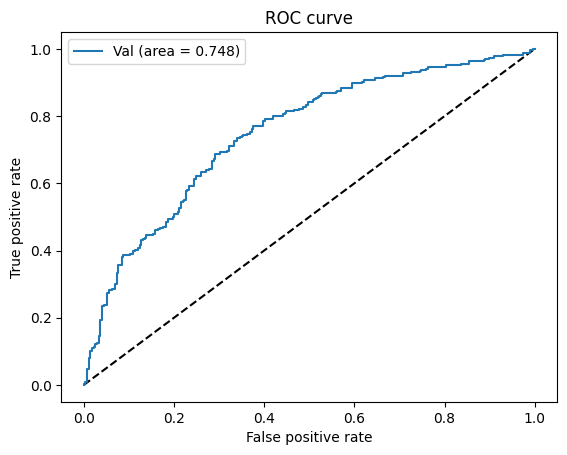

/var/folders/y_/834fx6dn3jj2fk1kcymz3mmm0000gn/T/ipykernel_1629/3065105991.py:5: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
/var/folders/y_/834fx6dn3jj2fk1kcymz3mmm0000gn/T/ipykernel_1629/3065105991.py:5: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
/var/folders/y_/834fx6dn3jj2fk1kcymz3mmm0000gn/T/ipykern

Recall at Precision of 80 is {} 0.38686131386861317


<Figure size 640x480 with 0 Axes>

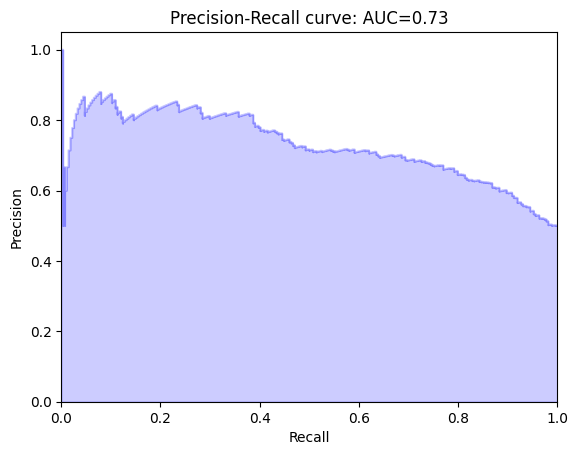

In [61]:
m = nn.Sigmoid()
if do_eval:
    eval_examples = processor.get_test_examples(data_dir)
    eval_features = convert_examples_to_features(
        eval_examples, label_list, max_seq_length, tokenizer)
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", eval_batch_size)
    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    if local_rank == -1:
        eval_sampler = SequentialSampler(eval_data)
    else:
        eval_sampler = DistributedSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    true_labels=[]
    pred_labels=[]
    logits_history=[]
    for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)
        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids,segment_ids,input_mask)

        logits = torch.squeeze(m(logits)).detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()

        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)

        true_labels = true_labels + label_ids.flatten().tolist()
        pred_labels = pred_labels + outputs.flatten().tolist()
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})

    string = 'logits_clinicalbert_'+readmission_mode+'_chunks.csv'
    df.to_csv(os.path.join(output_dir, string))

    df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

    fpr, tpr, df_out = vote_score(df_test, logits_history, readmission_mode, output_dir)

    string = 'logits_clinicalbert_'+readmission_mode+'_readmissions.csv'
    df_out.to_csv(os.path.join(output_dir,string))

    rp80 = vote_pr_curve(df_test, logits_history, readmission_mode, output_dir)

    result = {'eval_loss': eval_loss,
              'eval_accuracy': eval_accuracy,                 
              'global_step': global_step_check,
              'training loss': train_loss/number_training_steps,
              'RP80': rp80}

    output_eval_file = os.path.join(output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))


Download entire folder from AWS sagemaker to laptop:

In [ ]:
!zip -r -X ClinicalBERT3_results.zip './'

  adding: lost+found/ (stored 0%)
  adding: model/ (stored 0%)
  adding: model/early_readmission/ (stored 0%)
  adding: model/early_readmission/pytorch_model.bin (deflated 7%)
  adding: model/early_readmission/bert_config.json (deflated 47%)
  adding: ClinicalBERT3.ipynb (deflated 67%)
  adding: modeling_readmission.py (deflated 81%)
  adding: data/ (stored 0%)
  adding: data/3days/ (stored 0%)
  adding: data/3days/train.csv (deflated 65%)
  adding: data/3days/test.csv (deflated 79%)
  adding: data/3days/val.csv (deflated 78%)
  adding: data/discharge/ (stored 0%)
  adding: data/discharge/train.csv (deflated 66%)
  adding: data/discharge/test.csv (deflated 68%)
  adding: data/discharge/val.csv (deflated 68%)
  adding: data/2days/ (stored 0%)
  adding: data/2days/test.csv (deflated 78%)
  adding: pickle/ (stored 0%)
  adding: pickle/df_less_3.pkl